In [2]:
import numpy as np
import cv2
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import utils
from keras import preprocessing # image ImageDataGenerator
import pickle
import tensorflow as tf


In [3]:
current_directory = os.getcwd()
absolute_path = os.path.join(current_directory, "myData")
path= absolute_path

myList = os.listdir(path)
noOfClasses = len(myList)

print("Label(sınıf) sayısı: ",noOfClasses)

images = [] # Resimler burada depolanacak
classNo = [] # Sınıflar burada depolanacak

for i in range(noOfClasses):  # rakamlar
    myImageList = os.listdir(path + "/" + str(i))
    for j in myImageList:
        img = cv2.imread(path + "\\" + str(i) + "\\" + j)
        img = cv2.resize(img, (32, 32))
        images.append(img)  # resim ekler
        classNo.append(i) # rakam ekler


# print("Toplam resim:", images)
print("classNo:", classNo)

images = np.array(images) # resimleri numpy dizisine dönüştürür
classNo = np.array(classNo)

print("images.shape:", images.shape)
print("classNo.shape:", classNo.shape)

# Veri Ayırma
x_train, x_test, y_train, y_test = train_test_split(images, classNo, test_size= 0.5, random_state= 42) # test_size=0.5 veri setinin yarısını test veri seti olarak ayırır
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size= 0.2, random_state= 42) # test_size=0.2 veri setinin %20'sini doğrulama veri seti olarak ayırır

print("images_shape: ",images.shape)
print("x_train_shape: ",x_train.shape)
print("x_validation_shape: ",x_validation.shape)

# -----------------------------
# Ayıdığımız verileri grafik üzerinde Görselleştirme
# fig, axes = plt.subplots(3,1, figsize=(11, 11))
# fig.subplots_adjust(hspace=0.5)
# sns.countplot(y_train, ax=axes[0])
# axes[0].set_title("Y train")
print("y_train:", y_train)
# sns.countplot(y_test, ax=axes[1])
# axes[1].set_title("Y test")

# sns.countplot(y_validation, ax=axes[2])
# axes[2].set_title("Y validation")
#-----------------------------

# preprocess
def preProcess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img) # histogram eşitleme işlemi
    img = img/255 # normalizasyon 0-1 arasına getirir
    return img

# -----------------------------
# Deneme
# idx = 50
# img = preProcess(x_train[idx])
# img = cv2.resize(img, (300, 300))
# cv2.imshow("Preprocess", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# -----------------------------

# map fonksiyonu ile tüm resimler preprocess fonksiyonuna gönderilir
x_train = np.array(list(map(preProcess, x_train))) 
x_test = np.array(list(map(preProcess, x_test)))
x_validation = np.array(list(map(preProcess, x_validation)))

# Resimlerin boyutunu 32x32x1 yapar
# -1 içinde ki tüm verileri alır
x_train = x_train.reshape(-1, 32, 32, 1)
x_test = x_test.reshape(-1, 32, 32, 1)
x_validation = x_validation.reshape(-1, 32, 32, 1)


# data generate
# resimlerin üzerinde çeşitli işlemler yaparak veri setini genişletir
dataGen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                                                  height_shift_range=0.1,
                                                  zoom_range=0.2,
                                                  shear_range=0.1,
                                                  rotation_range=10)

# width_shift_range = 0.1 resmin yatayda 10% kaydırılmasını sağlar
# height_shift_range = 0.1 resmin dikeyde 10% kaydırılmasını sağlar
# zoom_range = 0.2 resmin 20% büyütülmesini veya küçültülmesini sağlar
# shear_range = 0.1 resmin 10% eğilmesini sağlar
# rotation_range = verilen derece değeri kadar resmin döndürülmesini sağlar

dataGen.fit(x_train)

# one hot encoding ile benzer işlem yapmaktadır
# keras için yapılır
# Etiketleri kategorik hale getirir
y_train = utils.to_categorical(y_train, noOfClasses)
y_test = utils.to_categorical(y_test, noOfClasses)
y_validation = utils.to_categorical(y_validation, noOfClasses)


model = models.Sequential()
model.add(layers.Conv2D(input_shape=(32, 32, 1), filters=8, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2))) # pixsel ekleme

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Dropout(0.2))
model.add(layers.Flatten())


model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=noOfClasses, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # modeli derler

batch_size = 250 #her bir adımda kaç resim işleneceğini belirler

# fit fonksiyonu modeli eğitim verileri ile eğitir
hist = model.fit(dataGen.flow(x_train, y_train, batch_size=batch_size), validation_data=(x_validation, y_validation), epochs=15, steps_per_epoch= x_train.shape[0]//batch_size,shuffle=1)
# x_train eğitelecek veriler y_train etiketler batch_size her bir adımda kaç resim işleneceğini belirler
# epoch değeri modelin kaç kez eğitileceğini belirler
# shuffle = verileri karıştırır.


# model_json = model.to_json()

# model.save("model_trained.h5")

# with open("model_trained.p", "w") as json_file:
#     json_file.write(model_json)


# pickle_out = open("model_trained.p", "wb")
# pickle.dump(model, pickle_out)
# pickle_out.close()

with open('model_trained.p', 'wb') as file_pi:
    pickle.dump(model, file_pi)
    print("Kaydedildi")


# değerlendirme


Label(sınıf) sayısı:  10
classNo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

c:\Users\90505\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


c:\Users\90505\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1807 - loss: 2.2453 - val_accuracy: 0.6171 - val_loss: 1.6634
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4000 - loss: 1.9212 - val_accuracy: 0.6033 - val_loss: 1.6081
Epoch 3/15


c:\Users\90505\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4716 - loss: 1.6912 - val_accuracy: 0.9085 - val_loss: 0.6005
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5960 - loss: 1.3286 - val_accuracy: 0.8927 - val_loss: 0.5799
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6673 - loss: 1.0703 - val_accuracy: 0.9311 - val_loss: 0.3127
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7440 - loss: 0.8465 - val_accuracy: 0.9341 - val_loss: 0.3057
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7715 - loss: 0.7207 - val_accuracy: 0.9449 - val_loss: 0.2022
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7760 - loss: 0.6853 - val_accuracy: 0.9449 - val_loss: 0.1950
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8132 - loss: 0.5943 - val_accuracy: 0.9508 - val_loss: 0.1536
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8280 - loss: 0.4852 - val_accuracy: 0.9488 - val_loss: 0.156

In [19]:
# model_json = model.to_json()

# model.save("model_trained.h5")

# with open("model_trained.p", "w") as json_file:
#     json_file.write(model_json)

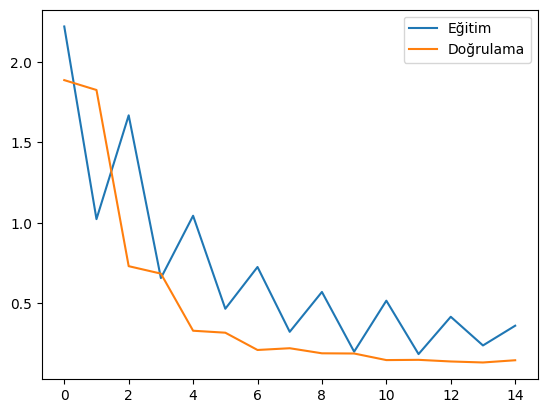

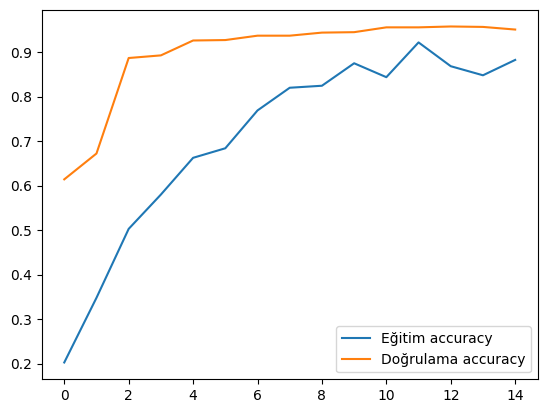

In [12]:
# Eğitim sırasındaki kayıp verileri
plt.figure()
plt.plot(hist.history['loss'], label='Eğitim loss')
plt.plot(hist.history['val_loss'], label='Doğrulama loss')
plt.legend()
plt.show()

# Eğitim sırasındaki doğruluk verileri
plt.figure()
plt.plot(hist.history['accuracy'], label='Eğitim accuracy')
plt.plot(hist.history['val_accuracy'], label='Doğrulama accuracy')
plt.legend()
plt.show()

In [13]:
score = model.evaluate(x_test, y_test, verbose=1) # verbose=1 eğitim sırasında çıktıları gösterir
print("Test loss:", score[0])
print("Test accuracy:", score[1])

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9568 - loss: 0.1258
Test loss: 0.132606640458107
Test accuracy: 0.9547244310379028


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


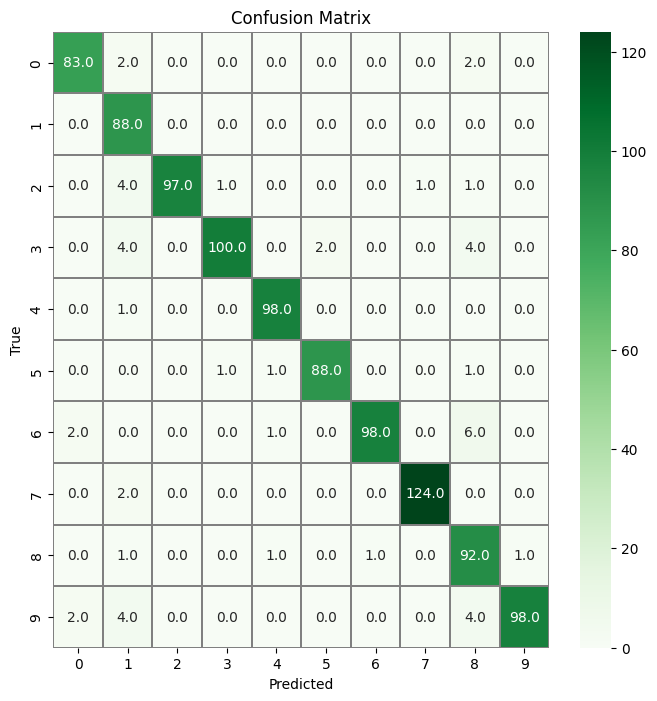

In [16]:
y_pred = model.predict(x_validation) # Sonuçlar

y_pred_classes = np.argmax(y_pred, axis=1)  # max değeri indexsi

y_true = np.argmax(y_validation, axis=1) # gerçek sınıf max değeri indexsi

cm = confusion_matrix(y_true, y_pred_classes) # doğru sınıfı ve tahmin edilen sınıfı karşılaştırır

f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt=".1f", ax=ax)
#annot =grafikteki sayıları gösterir
#linewidths = çizgi kalınlığı
#cmap = renk
#linecolor = çizgi rengi
#fmt = sayıların formatı(virgülden sonra kaç basamak olacak)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [3]:
import numpy as np
import keras

x = np.random.rand(4, 10 ,10, 128)
y = keras.layers.Conv2D(32, 3, activation="relu")(x)
print(y.shape)

(4, 8, 8, 32)
